<a href="https://colab.research.google.com/github/elhamod/BA865-2024/blob/main/hands-on/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now, that you know how to train an MLP, let's make minor changes to train a

##Things we will investigate:


- How to fine-tune a pre-trained model.
  - How to freeze layers.
  - How to train the model or a part of it.
- How to load data from disk.
- How to do image transformations.
- How to use LR scheduler


Here are some flags that you can turn on and off

In [1]:
enable_wandb = True
use_gpu = True


##Import some packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

This helps you check if GPU is available

In [3]:
gpu_available = torch.cuda.is_available()
gpu_available

True

Some extra fancy but optional packages:

- `torchmetrics` for calculating accuracy
- `wandb` for logging

In [4]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Hyper-parameters

Define your hyper-parameters here.

In [36]:
# Hyperparameters

configs = {
    "experiment_name": "not pretrained",
    "freeze_feature_extraction_layers": False,
    "pretrained":False,
    "efficientnet":False, # off-> Resnet18
    "data_augmentation":True,
    "transferlearning": True,

    # Data
    "img_dimensions" : (3,224,224),
    "batch_size" : 32,
    "num_classes" : 14,

    # CNN
    "filter_sizes" : [4,8],
    "kernel_size" : 5,
    "stride": 2,
    "padding":1,

    #Optimzation
    "learning_rate" : 0.01,
    "epochs" : 70,
    "weight_decay" : 0.00001
}





## Data

Load your dataset and create `DataLoaders` that handle the batching and shuffling.

Let's use this dataset: https://www.kaggle.com/datasets/danupnelson/14-celebrity-faces-dataset?resource=download

In [8]:
!unzip "/content/archive (10).zip"

Archive:  /content/archive (10).zip
  inflating: 14-celebrity-faces-dataset/data/train/anne_hathaway/316px-Anne_Hathaway_@_2018.09.15_Human_Rights_Campaign_National_Dinner,_Washington,_DC_USA_06194_(43805104245)_(cropped).jpg  
  inflating: 14-celebrity-faces-dataset/data/train/anne_hathaway/353px-Anne_Hathaway_2019_(cropped).jpg  
  inflating: 14-celebrity-faces-dataset/data/train/anne_hathaway/393px-Denzel_Washington_og_Anne_Hathaway_IMG_6550b_Harry_Wad.jpg  
  inflating: 14-celebrity-faces-dataset/data/train/anne_hathaway/398px-Anne_Hathaway_in_2017.png  
  inflating: 14-celebrity-faces-dataset/data/train/anne_hathaway/417px-Anne_Hathaway_in_2016.jpg  
  inflating: 14-celebrity-faces-dataset/data/train/anne_hathaway/428px-Anne_Hathaway_TIFF_2008.jpg  
  inflating: 14-celebrity-faces-dataset/data/train/anne_hathaway/443px-Anne_Hathaway_2013.jpg  
  inflating: 14-celebrity-faces-dataset/data/train/anne_hathaway/476px-Anne_Hathaway_(cropped)_(cropped).png  
  inflating: 14-celebrity-fa

In [9]:
# Transformations
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
if configs["data_augmentation"]:
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(0.5),
      transforms.Resize(224),       # Resize the image to 224x224 pixels while maintaining aspect ratio
      transforms.RandomCrop(224),
      transforms.RandomRotation(45),
      transforms.ColorJitter(),
      transforms.ToTensor(),               # Convert the image to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor using the mean and
                      std=[0.229, 0.224, 0.225])       # standard deviation of the ImageNet dataset
  ])
else:
  transform = transforms.Compose([
      transforms.Resize(224),       # Resize the image to 224x224 pixels while maintaining aspect ratio
      transforms.CenterCrop(224),
      transforms.ToTensor(),               # Convert the image to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor using the mean and
                      std=[0.229, 0.224, 0.225])       # standard deviation of the ImageNet dataset
  ])


import torchvision
train_dataset = torchvision.datasets.ImageFolder("/content/14-celebrity-faces-dataset/data/train", transform=transform)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

test_dataset = torchvision.datasets.ImageFolder("/content/14-celebrity-faces-dataset/data/val", transform=transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=configs["batch_size"], shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=configs["batch_size"], shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=configs["batch_size"], shuffle=False)

## Define and create your model

In [10]:
# MLP model
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            torch.nn.Conv2d(configs["img_dimensions"][0], configs["filter_sizes"][0], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.ReLU(),
            torch.nn.Conv2d(configs["filter_sizes"][0], configs["filter_sizes"][1], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(72, output_size) # We can determine the 72 here by doing calculations offline or looking at the error.
        )

    # Defines the forward pass.
    def forward(self, x):
        x = x.view(-1, configs["img_dimensions"][0], configs["img_dimensions"][1], configs["img_dimensions"][2])
        return self.model(x)


Create the model

In [37]:
import torchvision.models as models

if configs["transferlearning"]:
  # Load a pre-trained ResNet-18 model
  if not configs["efficientnet"]:
    model = models.resnet18(pretrained=configs["pretrained"])
  else:
    model = torch.hub.load("pytorch/vision", "efficientnet_b2", weights="EfficientNet_B2_Weights.IMAGENET1K_V1")
else:
  model = CNN(configs["num_classes"])

if gpu_available and use_gpu:
  model = model.cuda()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [27]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Replace the last layer(s)

In [38]:
if configs["transferlearning"]:
  if configs["efficientnet"]:
    model.classifier[1] = torch.nn.Sequential(torch.nn.Linear(1408, 100), torch.nn.ReLU(), torch.nn.Linear(100, configs["num_classes"]))
  else:
    model.fc = torch.nn.Sequential(torch.nn.Linear(512, 100), torch.nn.ReLU(), torch.nn.Linear(100, configs["num_classes"]))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Freeze other layers

In [39]:
if configs["transferlearning"]:
  if configs["freeze_feature_extraction_layers"]==True:
    # Freeze all layers except the last fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last fully connected layer
    if configs["efficientnet"]:
      for param in model.classifier[1].parameters():
          param.requires_grad = True
    else:
      for param in model.fc.parameters():
          param.requires_grad = True

use `torch-summary` for more info on the model

In [15]:
!pip install torchinfo

In [16]:
from torchinfo import summary

summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 14]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

## Loss

For classification, we use cross-entropy.

In [40]:
criterion = nn.CrossEntropyLoss()

##Optimizer

In [41]:
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=configs["learning_rate"], weight_decay=configs["weight_decay"])

## Training!

In [42]:
if enable_wandb:
  wandb.init(
    # Set the project where this run will be logged
    project="Transfer Learning",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=configs["experiment_name"],
    # Track hyperparameters and run metadata
    config=configs)

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▇▇▆▅▄▄▂▂▁▁▁▁▁▁▁▁
train_accuracy,▁▂▂▅▆▆▆▇█▇███████
val_accuracy,▁▃▁▄▄▄▅▅▇▆▇▄▆▅▇▇█
val_loss,▇█▇▅▄▂▂▅▂▁▂▄▃▃▃▂▁
epoch,17
loss,0.10343
train_accuracy,0.99432
val_accuracy,0.56818
val_loss,1.64308


Define some functions to calculate training and test accuracies

In [33]:
## There is a package called torchmetrics that makes calculating accuracy easier.
## Feel free to use it. However, here, I show the logic behind such calculations
# !pip install -U torchmetrics
# import torchmetrics

def get_accuracy(dataloader, model):
  acc = 0
  # <OR>
  # acc = torchmetrics.Accuracy()

  with torch.no_grad():
      for images, labels in dataloader:
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          outputs = model(images) # get predictions

          # Update accuracy for this batch
          acc = acc + torch.sum(torch.argmax(outputs, axis=1) == labels)
          # <OR>
          # acc.update(outputs, labels)


      # Compute the accuracy
      acc = acc/len(dataloader.dataset) # normalizes
      # <OR>
      # acc = acc.compute()

      return acc



In [21]:
def get_loss(loader):
  with torch.no_grad(): # Anything under torch.no_grad will be calculated with no gradients. Can only be used for testing, not training!

    loss = 0
    for i, (images, labels) in enumerate(loader): # The batches.
          # step1: Move data to cuda. Make sure the model is on cuda too!
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)

          # step 3: calculate the loss.
          loss = loss + criterion(outputs, labels)
    return loss/ len(loader)

Early-stopping class

In [22]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # If the new loss is lower than the old loss, reset the counter!
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Keep track of the best model by saving it on the hard drive.
            torch.save(model.state_dict(), "./best_model.pt")
        # otherwise, increment the counter.
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            # If there has been too many epochs with the loss being high, terminate.
            if self.counter >= self.patience:
                return True
        return False


Train!

In [43]:
if gpu_available and use_gpu:
  model = model.cuda()

In [44]:
early_stopper = EarlyStopper(patience=7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

# Training loop
for epoch in range(configs["epochs"]): # The epochs.
    for i, (images, labels) in enumerate(train_loader): # The batches.
        # step 1: Zero out the gradients.
        optimizer.zero_grad()

        # step 1.1 move data to cuda. Make sure the model is on cuda too!
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        # step2: Forward pass
        outputs = model(images)

        # step 3: calculate the loss.
        loss = criterion(outputs, labels)

        # step 4: Backward pass
        loss.backward()
        optimizer.step()

        # Print the loss
        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    # Compute total train accuracy
    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    validation_loss = get_loss(val_loader)
    wandb.log({"val_loss": validation_loss})

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Validation Loss: {validation_loss.item():.4f}, Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {test_acc.item():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, "LR": {optimizer.param_groups[0]['lr']}, "train_accuracy": train_acc.item(), "val_accuracy": test_acc.item()})

    scheduler.step(validation_loss)

    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break



Epoch 1  batch 1 . Training Loss:  2.6304824352264404
Epoch [1/70], LR: 0.01, Validation Loss: 2.6922, Train Accuracy: 0.1364, Validation Accuracy: 0.0909
Epoch 2  batch 1 . Training Loss:  2.501993179321289
Epoch [2/70], LR: 0.01, Validation Loss: 2.7652, Train Accuracy: 0.1136, Validation Accuracy: 0.0227
Epoch 3  batch 1 . Training Loss:  2.552568197250366
Epoch [3/70], LR: 0.01, Validation Loss: 2.8761, Train Accuracy: 0.1875, Validation Accuracy: 0.0455
Epoch 4  batch 1 . Training Loss:  2.5104830265045166
Epoch [4/70], LR: 0.01, Validation Loss: 2.8530, Train Accuracy: 0.1818, Validation Accuracy: 0.0909
Epoch 5  batch 1 . Training Loss:  2.4537508487701416
Epoch [5/70], LR: 0.01, Validation Loss: 2.8724, Train Accuracy: 0.1705, Validation Accuracy: 0.0455
Epoch 6  batch 1 . Training Loss:  2.333998203277588
Epoch [6/70], LR: 0.003, Validation Loss: 2.9025, Train Accuracy: 0.2045, Validation Accuracy: 0.0909
Epoch 7  batch 1 . Training Loss:  2.4275131225585938
Epoch [7/70], LR: 

Test

In [ ]:
print("last model performance on Test set:", get_accuracy(test_loader, model))

# Once training is done, load the best model (might not be the last model due to early stopping)
model.load_state_dict(torch.load("./best_model.pt"))
acc = get_accuracy(test_loader, model)
print("best model performance Test set:", acc)

if enable_wandb:
  wandb.summary['Test Accuracy'] = acc.item()

last model performance on Test set: tensor(0.5000, device='cuda:0')
best model performance Test set: tensor(0.4429, device='cuda:0')


Test

In [ ]:
if enable_wandb:
  wandb.finish()

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▇▇▆▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁
train_accuracy,▁▂▄▅▅▆▆▆▇▇▇█████████
val_accuracy,▂▁▄▅▂▆▅▄▇▅█▆▇█▇█▇▆▇▇
val_loss,██▇▅▆▄▃▃▂▂▂▂▁▁▂▁▂▂▁▁
Test Accuracy,0.44286
epoch,20
loss,0.12318
train_accuracy,1.0
val_accuracy,0.45455
val_loss,1.66896


The resulting WandB dashboard: https://api.wandb.ai/links/phylonn/vnlv5oak

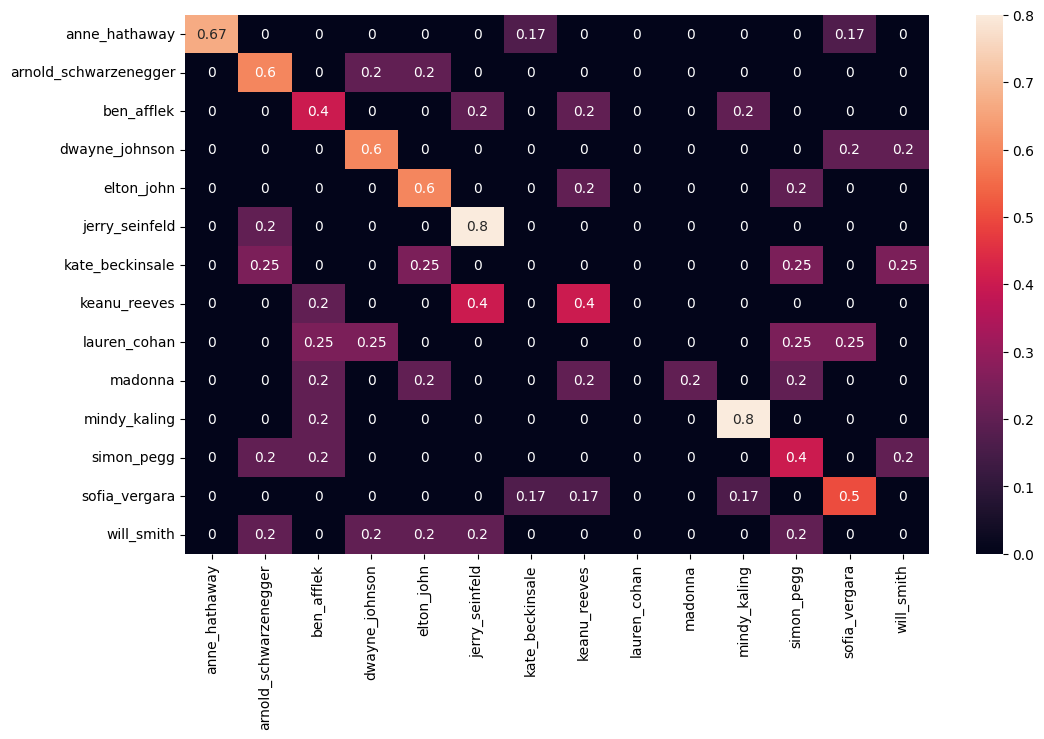

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs.cuda()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = test_dataset.class_to_idx.keys()

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')